In [571]:
import numpy as np
import matplotlib.pyplot as plt
import time
import torch
from scipy.stats import linregress
import random

In [572]:
### CONFIGURAÇÔES:

# PRECISÃO:
precision = torch.complex128
precision2 = torch.float64

# LISTAS:
ns = [10, 20, 50, 100, 150, 250, 500, 1000, 1500, 2000, 3000] # Tamanhos das matrizes usadas nos cálculos
sizes_1b = list(range(4,105, 10))

# ITERAÇÔES:
num_2a = 2000
num_2c = 9000
num_2d = 10000
max_iter_powerIteration = 1000
max_iter_inverseIteration = 1000
max_iter_praticalQR = 1000

# CORES:
colorHermitan = '#4287f5'
colorNormal = "#e61e1e"

# PLOTS:
gridAlpha = 0.5

# Questão 1. Redução à forma de Hessemberg.

## a) Cálculo dos refletores.

In [573]:
def to_hessemberg(A: torch.Tensor, computeQ=True, hermitan=False):
    """
    Transforma uma matriz A em forma de Hessenberg usando reflexões de Househprever.

    Parâmetros:
    - A (torch.Tensor): matriz quadrada real ou complexa de dimensão (m x m)
    - hermitan (Bool): booleano para dizer se a matriz A de entrada é simétrica ou não

    Retorna:
    - v_list: lista de vetores de Househprever aplicados (um por iteração)
    - H: matriz de Hessenberg superior resultante (semelhante a A)
    - Q: matriz ortogonal/acumulada das reflexões, tal que Q^T A Q = H
    """
    m = A.shape[0]
    H = A.clone()  # Cópia da matriz original para evitar modificações diretas
    v_list = []    # Lista para armazenar os vetores de Househprever
    if computeQ: Q = torch.eye(m, dtype=A.dtype, device=A.device)  # Inicializa Q como identidade

    # ALgoritmo padrão
    if not hermitan:
        for k in range(m - 2):
            # Seleciona a coluna abaixo da diagonal para zerar
            x = H[k+1 : m, k]
            v_k = x.clone()

            # Calcula o vetor de Househprever
            norm_x = torch.norm(x)
            if x[0] != 0:
                phase = x[0] / torch.abs(x[0])  # Fator de fase: x[0]/|x[0]|
                v_k[0] += phase * norm_x
            else:
                v_k[0] += norm_x

            # Normaliza v_k
            v_k = v_k / torch.norm(v_k)
            v_list.append(v_k)

            # Aplica reflexão de Househprever à esquerda: H = (I - 2vvᵗ) H
            left_mul = torch.matmul(v_k.conj().unsqueeze(0), H[k+1 : m, k : m])
            H[k+1 : m, k : m] -= 2 * torch.ger(v_k, left_mul.squeeze(0))

            # Aplica reflexão à direita: H = H (I - 2vvᵗ)
            right_mul = torch.matmul(H[:, k+1 : m], v_k)
            H[:, k+1 : m] -= 2 * torch.ger(right_mul, v_k.conj())

            if computeQ:
                # Atualiza a matriz Q acumulando as transformações
                q_mul = torch.matmul(Q[:, k+1:m], v_k)
                Q[:, k+1:m] -= 2 * torch.ger(q_mul, v_k.conj())
    
    # Algoritmo Hermitana
    else:
        for k in range(m - 2):
            # Seleciona a coluna abaixo da diagonal para zerar
            x = H[k+1 : m, k]
            v_k = x.clone()

            # Calcula o vetor de Househprever
            norm_x = torch.norm(x)
            factor = (x[0] / torch.abs(x[0])) * norm_x
            if x[0] != 0:
                v_k[0] += factor
            else:
                v_k[0] += norm_x

            # Normaliza v_k
            v_k = v_k / torch.norm(v_k)
            v_list.append(v_k)

            # Vetores de suporte para a otimização
            p = 2 * torch.mv(H[k+1:m, k+1:m], v_k)
            w = p - torch.dot(p.conj(), v_k) * v_k

            # Aplica a atualização que equivale a P*H*P, mas de forma mais eficiente
            H[k+1:m, k+1:m] -= (torch.ger(v_k, w.conj()) + torch.ger(w, v_k.conj()))

            # Altera diretamente os valores da "cabeça" do vetor coluna e seu simétrico transposto  
            H[k+1, k] = - factor
            H[k, k+1] = - factor.conj()

            # Zera diretamente os valores da matriz que seriam zeros ao fim da iteração
            H[k+2:m, k] = 0.0
            H[k, k+2:m] = 0.0

            if computeQ:
                # Atualiza a matriz Q acumulando as transformações
                q_mul = torch.mv(Q[:, k+1:m], v_k)
                Q[:, k+1:m] -= 2 * torch.ger(q_mul, v_k.conj())

    if computeQ:
        return v_list, H, Q
    else:
        return v_list, H

## b) Verificação da função.

### Ideia.
- Aqui iremos verificar alguns pontos:
    - $||A - QHQ^*||$ deve resultar um valor próximo de zero
    - $||Q^*Q - I||$ também deve estar próximo de zero

- Para cada uma dessas condições, utilizarei várias matrizes A: simétricas e não simétricas, de diferentes tamanhos.

### Resultados.
- Os gráficos mostram que os erros estão baixos, ou seja, o algoritmo se mostra promissor.

In [574]:
def norm1(A: torch.tensor, H: torch.tensor, Q: torch.tensor) -> float:
    """Calcula a norma da diferença entre A e a sua reconstrução a partir de H e Q

    Args:
        A (torch.tensor): Matriz A
        H (torch.tensor): Matriz H de A
        Q (torch.tensor): Matriz Q de A

    Returns:
        float: o valor da norma
    """
    norm = torch.norm(A - Q @ H @ Q.conj().T).item()
    return norm

def norm2(Q: torch.tensor) -> float:
    """Calcula a norma de QTQ - I

    Args:
        Q (torch.tensor): Matriz ortogonal

    Returns:
        float: norma
    """
    norm = torch.norm(Q.conj().T @ Q - torch.eye(Q.shape[0], dtype=Q.dtype, device=Q.device)).item()
    return norm

In [575]:
b_norm1A_hermitan_list = []
b_norm2A_hermitan_list = []
b_norm1A_normal_list = []
b_norm2A_normal_list = []

for tamanho in sizes_1b:
    A = torch.randn((tamanho,tamanho), dtype=precision)

    # Tornar A hermitana:
    A_hermitan = (A + A.conj().T) / 2

    # Amazenar os resultados 
    _, H, Q = to_hessemberg(A_hermitan)
    b_norm1A_normal_list.append(norm1(A_hermitan, H, Q))
    b_norm2A_normal_list.append(norm2(Q))

    # Armazenar os resultados
    _, H, Q = to_hessemberg(A_hermitan, hermitan=True)
    b_norm1A_hermitan_list.append(norm1(A_hermitan, H, Q))
    b_norm2A_hermitan_list.append(norm2(Q))

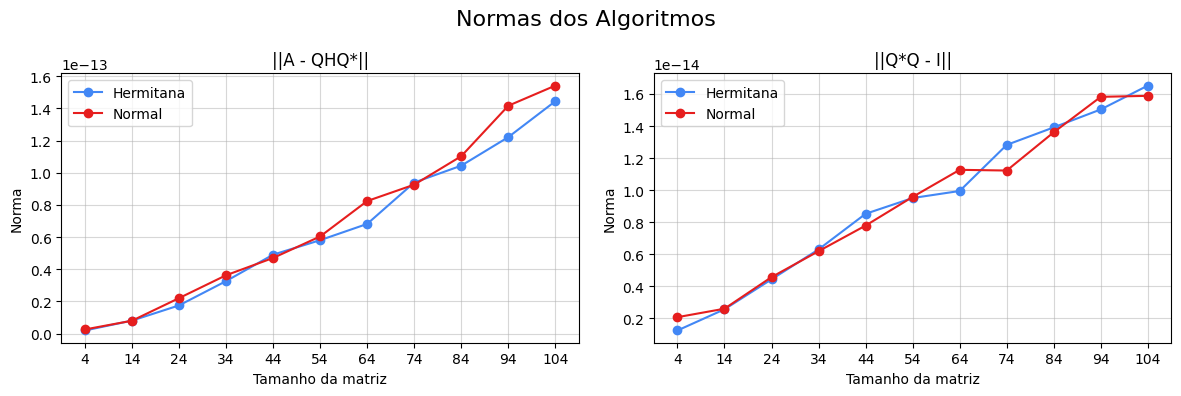

In [576]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(sizes_1b, b_norm1A_hermitan_list, '-o', label="Hermitana", color=colorHermitan)
plt.plot(sizes_1b, b_norm1A_normal_list, '-o',label="Normal", color=colorNormal)
plt.title('||A - QHQ*||')
plt.xlabel('Tamanho da matriz')
plt.ylabel('Norma')
plt.xticks(sizes_1b)
plt.grid(alpha=gridAlpha)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(sizes_1b, b_norm2A_hermitan_list, '-o', label="Hermitana", color=colorHermitan)
plt.plot(sizes_1b, b_norm2A_normal_list, '-o', label="Normal", color=colorNormal)
plt.title('||Q*Q - I||')
plt.ylabel('Norma')
plt.xlabel('Tamanho da matriz')
plt.xticks(sizes_1b)
plt.grid(alpha=gridAlpha)
plt.legend()

plt.suptitle('Normas dos Algoritmos', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])

plt.tight_layout()
plt.show()

## c) Complexidade.

### Ideia.
- Foram testadas matrizes, hermitanas e normais, de tamanhos variando de 10 a 3000. Com passos cada vez maiores : 10, 20, 50, 100, ...
- Para cada matriz é anotado o tempo de execução, ao final criando um gráfico com todos os tempos.
- Por fim, é usado um regressor linear para estimar a ordem da complexidade da função obtida, ou seja, do algoritmo desenvolvido. 
- A teoria nos mostra que a ordem de complexidade do algoritmo normal e o hermitano para a decomposição de Hessenberg são, respectivamente, aproximadamente $O(\frac{10}{3}n^3)$ e $O(\frac{4}{3}n^3)$. Porém, devemos nos atentar que, quando tentamos estimar a ordem de complexidade usando o tempo de execução, a forma como o algoritmo é computado é importante. Por exemplo, um pode computar com apenas um thread da CPU, enquanto outro pode usar, para o mesmo cálculo, toda a sua GPU. Este problema de estimar se torna ainda pior quando pensamos em diferentes arquiteturas de computadores.

### Conclusão.
- Em meu computador, é estimado aproximadamente $O(n^{2.09})$ e $O(n^{2.01})$ para o algoritmo normal e o hermitano, respectivamente. Porém, quando a ordem das matrizes tendessem ao infinito, os benefícios do paralelismo da biblioteca seriam superados, assim atingindo as complexidades $O(\frac{10}{3}n^3)$ e $O(\frac{4}{3}n^3)$.

### Bônus.
- Também foi coletado o erro das estimações feitas para as decomposições. Assim como anteriormente para matrizes menores, eles também se mostraram baixos para matrizes de ordens superiores.


In [577]:
def tempo_medio_hessemberg(n, func, device='cuda' if torch.cuda.is_available() else 'cpu', hermitan=False, computeQ=True):
    """
    Mede o tempo médio de execução da transformação de Hessenberg para uma matriz de tamanho n.

    Parâmetros:
    - n (int): dimensão da matriz quadrada.
    - func (function): função que realiza a transformação (ex: to_hessemberg).
    - device (str): 'cpu' ou 'cuda' para indicar onde executar a operação.
    - dtype: tipo de dado dos tensores (ex: torch.float64).
    - hermitan (bool): se True, gera matriz hermitana.

    Retorna:
    - tempo médio por execução (float)
    - v_list: lista de vetores de Househprever usados
    - H: matriz Hessenberg resultante
    - Q: matriz ortogonal acumulada das reflexões
    - A: matriz original usada para teste
    """
    # Gera matriz aleatória no dispositivo e tipo definidos
    A = torch.rand((n, n), dtype=precision, device=device)
    if hermitan:
        A = (A + A.conj().T) / 2  # Simetriza a matriz, se solicitado

    start = time.time()
    count = 0
    elapsed = 0

    # Executa transformações repetidamente até que passe 1 segundo
    while elapsed < 1.0:
        v_list, H, Q = func(A.clone(), computeQ=computeQ, hermitan=hermitan)  # Usa cópia para não modificar A
        count += 1
        elapsed = time.time() - start

    media_tempo = elapsed / count
    # Retorna tempo médio por execução e os resultados da última execução
    return media_tempo, v_list, H, Q, A


In [ ]:
c_hermitan_times = []
c_normal_times = []
c_norm1A_hermitan_list = []
c_norm2A_hermitan_list = []
c_norm1A_normal_list = []
c_norm2A_normal_list = []

for n in ns:
    # Para hermitana :
    media_tempo_hermitan, _, H, Q, A_hermitan = tempo_medio_hessemberg(n, to_hessemberg, hermitan=True)
    c_hermitan_times.append(media_tempo_hermitan)
    c_norm1A_hermitan_list.append(norm1(A_hermitan, H, Q))
    c_norm2A_hermitan_list.append(norm2(Q))

    # Para uma matriz não necessáriamente hermitana:
    media_tempo_normal, _, H, Q, A = tempo_medio_hessemberg(n, to_hessemberg, hermitan=False)
    c_normal_times.append(media_tempo_normal)
    c_norm1A_normal_list.append(norm1(A, H, Q))
    c_norm2A_normal_list.append(norm2(Q))

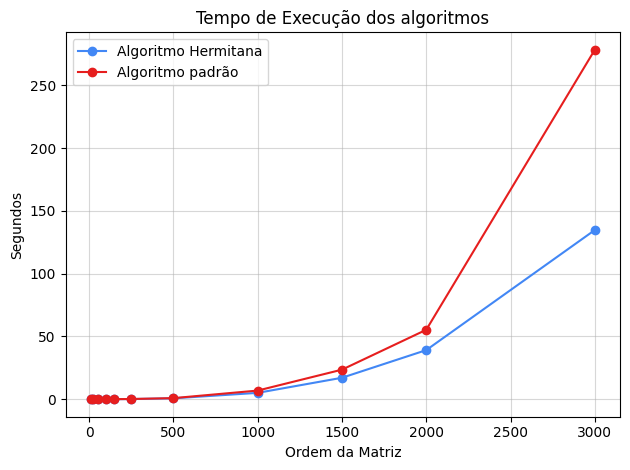

In [ ]:
plt.plot(ns,c_hermitan_times, '-o', label='Algoritmo Hermitana', color=colorHermitan)
plt.plot(ns,c_normal_times, '-o', label="Algoritmo padrão", color=colorNormal)

plt.title('Tempo de Execução dos algoritmos')
plt.xlabel('Ordem da Matriz')
plt.ylabel("Segundos")
plt.legend()
plt.grid(alpha=gridAlpha)
plt.tight_layout()
plt.show()


In [ ]:
logs_n = np.log(ns)
c_logs_hermitan_times = np.log(c_hermitan_times)
c_logs_normal_times = np.log(c_normal_times)
c_slope_hermitan, intercept, *_ = linregress(logs_n, c_logs_hermitan_times)
c_slope_normal, intercept, *_ = linregress(logs_n, c_logs_normal_times)

print(f"Complexidade estimada para normal: O(n^{c_slope_normal:.2f})")
print(f"Complexidade estimada para simetrica: O(n^{c_slope_hermitan:.2f})")

Complexidade estimada para normal: O(n^2.11)
Complexidade estimada para simetrica: O(n^1.98)


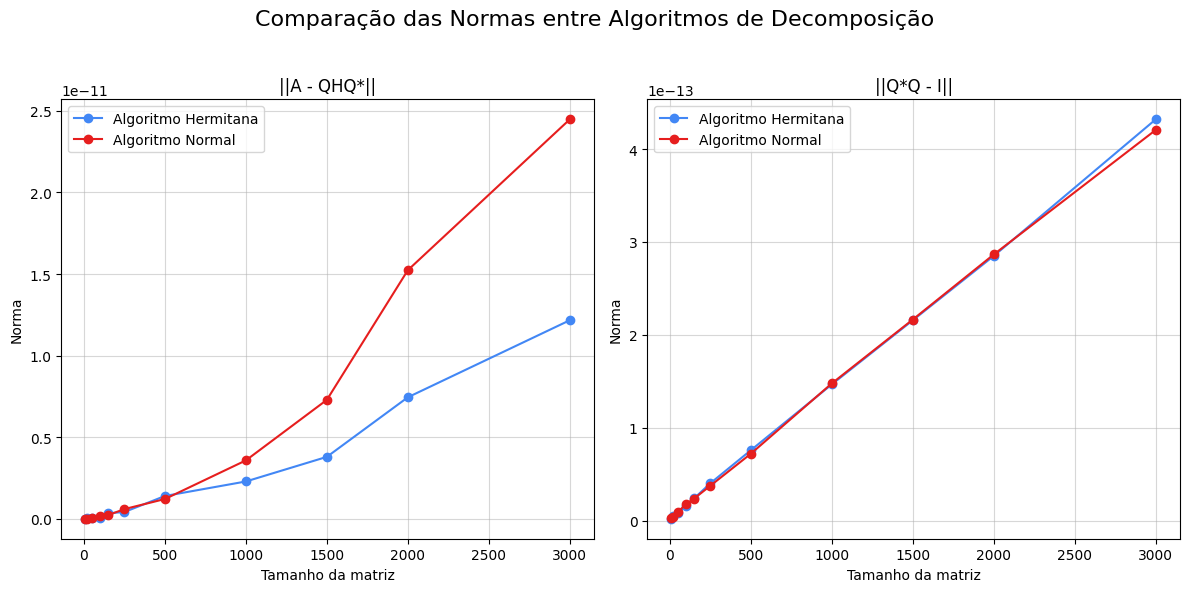

In [ ]:
plt.figure(figsize=(12,6))

plt.subplot(1,2,1)
plt.plot(ns, c_norm1A_hermitan_list, '-o', label="Algoritmo Hermitana", color=colorHermitan)
plt.plot(ns, c_norm1A_normal_list, '-o', label="Algoritmo Normal", color=colorNormal)
plt.title('||A - QHQ*||')
plt.xlabel('Tamanho da matriz')
plt.ylabel('Norma')
plt.grid(alpha=gridAlpha)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(ns, c_norm2A_hermitan_list, '-o', label="Algoritmo Hermitana", color=colorHermitan)
plt.plot(ns, c_norm2A_normal_list, '-o', label="Algoritmo Normal", color=colorNormal)
plt.title('||Q*Q - I||')
plt.ylabel('Norma')
plt.xlabel('Tamanho da matriz')
plt.grid(alpha=gridAlpha)
plt.legend()

plt.suptitle('Comparação das Normas entre Algoritmos de Decomposição', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])  
plt.show()


## d) Diferenças entre os algoritmos. 

### Contexto.
- Na função *to_hessemberg()* é possível passar um argumento, $hermitan$, para que ela saiba qual algoritmo irá realizar.
- Como dito anteriormente, a complexidade desta parte do algortimo muda, e, segundo a teoria, seria $O(\frac{4}{3}n^3)$. 
- A explicação para tal feito, vem do fato de que, como uma matriz hermitana permanece hermitana durante as iterações da decomposição, zeros serão adicionados nas linhas ao mesmo passo que nas colunas simétricas à elas.


### Ideia.
Olhemos para o processo dentro de uma iteração de uma matriz $A$ de ordem $4$ hermitana:         
$
\\
\\
A = \begin{bmatrix}
a_{11} & a_{12} & a_{13} & a_{14} \\
a_{21} & a_{22} & a_{23} & a_{24} \\
a_{31} & a_{32} & a_{33} & a_{34} \\
a_{41} & a_{42} & a_{43} & a_{44} \\
\end{bmatrix}
$
$
QA = \begin{bmatrix}
a_{11} & a_{12} & a_{13} & a_{14}  \\
a_{21}^{\prime} & a_{22}^{\prime} & a_{23}^{\prime} & a_{24}^{\prime}  \\
0 & a_{32}^{\prime} & a_{33}^{\prime} & a_{34}^{\prime}  \\
0 & a_{42}^{\prime} & a_{43}^{\prime} & a_{44}^{\prime}  \\
\end{bmatrix}
$
$
QAQ^* = \begin{bmatrix}
a_{11} & a_{12}^{\prime\prime} & 0 & 0 \\
a_{21}^{\prime\prime} & a_{22}^{\prime\prime} & a_{23}^{\prime\prime} & a_{24}^{\prime\prime}  \\
0 & a_{32}^{\prime\prime} & a_{33}^{\prime\prime} & a_{34}^{\prime\prime}  \\
0 & a_{42}^{\prime\prime} & a_{43}^{\prime\prime} & a_{44}^{\prime\prime}  \\
\end{bmatrix}
$

Perceba que apenas precisamos calcular os valores dentro do bloco inferior direito $A[1:4, 1:4]$ e o valor de $a_{21}^{\prime\prime}$. 

- $a_{21}^{\prime\prime}:$
    - Seja $x = A[1:4, 0]$.
    - É claro que o valor de $a_{21}^{\prime\prime} = a_{12}^{\prime\prime} = -sign(x[0])*||x||$.
- $A[1:4, 1:4]$:
    - Seja $H = A[1:4, 1:4]$.
    - Podemos realizar operações diretamente nessa $H$.
    $$
    H^{\prime}=Q^{\prime} H (Q^{\prime})^*
     = (I - 2vv^*) H (I - 2vv^*)^*
    $$
    - onde 
    $$
    v = \frac{x}{||x||}
    $$
    - Abrindo a expressão:
    $$
    H^{\prime} = H - 2vv^*H - 2Hvv^* + 4vv^*Hvv^*  
    $$
    - Podemos alocar 
    $$
    p = Hv
    $$
    $$
    H^{\prime} = H - 2vp^* - 2vv^*pv^* - 2pv^* - 2vv^*pv^* \\
    H^{\prime} = H - 2v(p^* - v^*av^*) - 2(p - vv^*p)v^*
    $$
    - Podemos também alocar 
    $$
    w = p - vv^*p
    $$
    - Substituindo, temos uma equação proposta:
    $$
    H^{\prime} = H - 2vw^* -2wv^* 
    $$ 
    - Logo, para esta parte da iteração, basta calcular $p$ e $w$ e utilizar na equação proposta.

### Conclusão.

- Quando estamos trabalhando com uma matriz Hermitana, pode ser útil explorar a sua simetrica em algoritmos. 
- Para o algoritmo que transforma uma matriz em sua forma de hessemberg foi provado acima que este benefício simétrico aumenta a performance do algoritmo. 


---

# Questão 2. Matrizes Ortogonais.

## a) Um pouco de teoria. 


### i. O que você pode dizer dos autovalores de uma matriz ortogonal?
Seja $Q$ uma matriz ortogonal e $v$ um autovetor associado à esta matriz, ou seja, 

$$
Q^TQ = I
$$

e
$$
Qv = \lambda v
$$

Podemos realizar um pequeno truque:

$$
v^Tv = (Qv)^T(Qv) = \lambda v^T \lambda v = \lambda^2 v^Tv
$$

implicando em 

$$
v^Tv = \lambda^2 v^Tv
$$

como $v^tv$ é sempre maior do que zero, então

$$
|\lambda| = 1
$$

ou seja, 

$$
\lambda = e^{i\phi}, \phi \isin \R
$$


### ii. Implicação para o método da potência.

#### Ideia.
Podemos olhar para dois pontos de realizar o método da potência com uma matriz ortogonal:

- Olhando para a sua propriedade de rotação e alongamento:
    - Repare que se $x$ é um vetor no espaço, então $||Qx|| = ||x||$, pois $Q$ é ortogonal. Assim, podemos ver que estamos apenas rotacionando nosso vetor no espaço, sem alongar ou contrair ele.
    - A cada iteração, aplicamos $||Qx^{(k)}||$, sempre rotacionando $x$ no círculo unitário. Ou seja, a matriz $Q$ acaba não tendo tanta liberdade para movimentar o nosso vetor no espaço, dificultando a convergência do método.
- Olhando para as propriedades de seus autovalores:
    - Tenhamos em mente o vetor $x^{(k)}$ da iteração $k$:
    $$
    x^{(k)} = c_k\lambda_1^k(a_1q_1 + a_2(\lambda_2/\lambda_1)^kq_2 + \cdots + a_n(\lambda_n/\lambda_1)^kq_n)
    $$
    - Quando $\lambda_1$ é maior, em módulo, do que os outros autovalores, as frações $\lambda_i/\lambda_1 \simeq 0$, logo
    $$
    x^{(k)} \simeq c_ka_1\lambda_1q_1
    $$
    - Como o método da potência visa levar um vetor aleatório $x$ para próximo do autovetor correspondente ao autovalor dominante, ou seja, de maior módulo, o algoritmo terá dificuldades para convergir caso a diferença entre o maior autovalor e o segundo maior autovalor, em módulo, seja pequena. 

#### Conclusão.
- Como estimado nas hipóteses acima, a convergência do método da potência para matrizes ortogonais tende a ser baixa.

In [ ]:
def powerIteration(A: torch.Tensor, maxIteration: int = max_iter_powerIteration, tolerance: float = 1e-12, precision=precision2): 
    """ 
    Aplica o método da potência para estimar o autovalor dominante da matriz A.
    
    VERSÃO MELHORADA: Evita falsas convergências verificando também a estabilidade
    do autovetor, não apenas do autovalor.

    Parâmetros: 
    - A (torch.Tensor): matriz quadrada de entrada. 
    - maxIteration (int): número máximo de iterações.
    - tolerance (float): tolerância para convergência do autovalor E do autovetor.

    Retorna: 
    - Aproximação do autovalor dominante (float). 
    - Numero de iterações realizadas. 
    """ 
    precision = A.dtype
    v = torch.randn(A.shape[1], dtype=precision)
    v = v / torch.norm(v, p=2)
    
    # A primeira estimativa do autovalor
    lmb_prev = torch.dot(v.conj(), A @ v)
    
    num_iter = 0 
    for i in range(maxIteration): 
        num_iter += 1 
        w = torch.matmul(A, v)
        v_new = w / torch.norm(w)
        
        # Estima o novo autovalor
        lmb_new = torch.dot(v_new.conj(), A @ v_new)

        # 1. Verifica a mudança no autovalor 
        eigenvalue_change = abs(lmb_new - lmb_prev)

        # 2. Verifica a mudança no autovetor 
        #    Calcula a distância para v_new e para -v_new e pega a menor.
        eigenvector_change = torch.min(torch.norm(v - v_new), torch.norm(v + v_new))

        # O algoritmo converge se AMBOS o autovalor E o autovetor pararem de mudar.
        if eigenvalue_change < tolerance and eigenvector_change < tolerance: 
            break 

        # Atualiza v e lmb para a próxima iteração 
        v = v_new
        lmb_prev = lmb_new

    # Retorna a estimativa final do autovalor dominante 
    final_lmb = torch.dot(v.conj(), torch.matmul(A, v))
    return final_lmb, num_iter


In [ ]:
a_num_convergence_Q = 0
a_num_convergence_A = 0
a2_num_iter_A_median = 0
a2_num_iter_Q_median = 0
total_error_A = 0.0
total_error_Q = 0.0
for _ in range(num_2a):
    A = torch.randn((4,4), dtype=precision2)
    _, _, Q = to_hessemberg(A)
    
    lmb_pred_Q, a_num_iter_Q = powerIteration(Q) 

    if a_num_iter_Q < max_iter_powerIteration:
        a2_num_iter_Q_median += a_num_iter_Q / num_2a
        a_num_convergence_Q += 1
        
        # 2. ADICIONE estas 3 linhas dentro do if para calcular o erro de Q
        true_eigenvalues_Q = torch.linalg.eigvals(Q)
        true_dominant_lmb_Q = true_eigenvalues_Q[torch.argmax(torch.abs(true_eigenvalues_Q))]
        total_error_Q += torch.abs(lmb_pred_Q - true_dominant_lmb_Q)

    lmb_pred_A, a_num_iter_A = powerIteration(A)

    if a_num_iter_A < max_iter_powerIteration:
        a2_num_iter_A_median += a_num_iter_A / num_2a
        a_num_convergence_A += 1
        
        # 2. ADICIONE estas 3 linhas dentro do if para calcular o erro de A
        true_eigenvalues_A = torch.linalg.eigvals(A)
        true_dominant_lmb_A = true_eigenvalues_A[torch.argmax(torch.abs(true_eigenvalues_A))]
        total_error_A += torch.abs(lmb_pred_A - true_dominant_lmb_A)

avg_error_A = a_2_total_error_A / a_num_convergence_A if a_num_convergence_A > 0 else 0
avg_error_Q = a_2_total_error_Q / a_num_convergence_Q if a_num_convergence_Q > 0 else 0

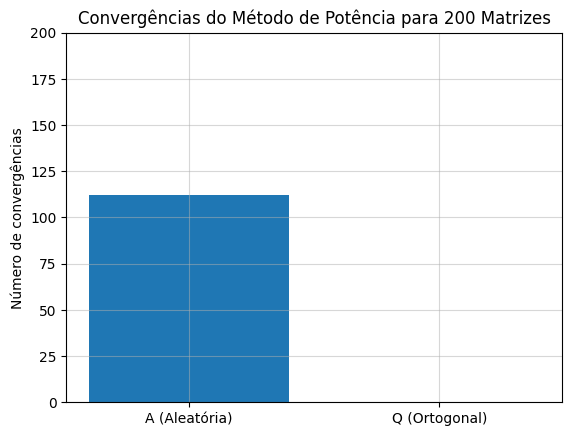

In [ ]:
plt.bar(['A (Aleatória)', 'Q (Ortogonal)'], [a_num_convergence_A, a_num_convergence_Q])
plt.ylim((0, num_2a))
plt.title(f'Convergências do Método de Potência para {num_2a} Matrizes')
plt.ylabel('Número de convergências')
plt.grid(alpha=gridAlpha)
plt.show()

In [43]:
print(f"Número de convergências para A: {a_num_convergence_A}/{num_2a}")
print(f"Número de iterações médias para A (aleatório): {int(a2_num_iter_A_median)}")
if a_num_convergence_A > 0:
    print(f"Erro médio para A (convergentes): {avg_error_A.item():.4e}")

# Adicione esta linha junto aos prints de Q
print()
print(f"Número de convergências para Q: {a_num_convergence_Q}/{num_2a}")
print(f"Número de iterações médias para Q (ortogonal): {int(a2_num_iter_Q_median) if a_num_convergence_Q != 0 else max_iter_powerIteration}")
if a_num_convergence_Q > 0:
    print(f"Erro médio para Q (convergentes): {avg_error_Q.item():.4e}")

Número de convergências para A: 75/200
Número de iterações médias para A (aleatório): 19
Erro médio para A (convergentes): 4.8342e-13

Número de convergências para Q: 0/200
Número de iterações médias para Q (ortogonal): 100


### iii. Implicação para a iteração inversa.
#### Ideia.

- Em contra partida à necessidade de ter um autovalor dominante, com módulo relevantemente maior que os outros, no algoritmo do método das potências, o método da iteração inversa não é limitado por esta condição.
- Já que o nosso valor $\mu$ escolhido fará com que o método tenda a convergir para o autovalor mais próximo dele, não precisamos nos preocupar com o autovalor dominante.
- Podemos agora nos beneficiar do fato de que todos os autovalores de $Q$ estarão no círculo de raio unitário: ao escolhermos um shift dentro dele sempre iniciaremos perto de um autovalor. Assim, nosso algoritmo tenderá a ser mais rápido do que para aquelas matrizes que não possuem esta propriedade.  

#### Conclusão.

- Como dito nas hipóteses acima, o fato de estarmos aplicando o método da iteração inversa para uma matriz ortogonal não impacta negativamente em sua convergência, na real, ele até mesmo ajuda.

In [ ]:
def inverseIteration(A: torch.Tensor, maxIteration: int=max_iter_inverseIteration, tolerance: float=1e-12, u=None, printIterations=False):
    """
    Realiza o método da iteração inversa para encontrar um autovalor dominante próximo ao shift u.

    Parâmetros:
    - A (torch.Tensor): matriz quadrada.
    - maxIteration (int): número máximo de iterações (default: 10000).
    - min_distance (float): tolerância mínima para a convergência do autovalor (default: 1e-16).
    - u (float ou None): shift (valor estimado próximo ao autovalor desejado). Se None, um aleatório é usado.
    - printIterations (bool): se True, imprime o número de iterações realizadas.

    Retorna:
    - lmb1 (float): autovalor aproximado.
    - i (int): número de iterações realizadas.
    """
    # Se nenhum shift for fornecido, usa um aleatório
    if u is None:
        u = float(random.random())

    precision = A.dtype

    # Dimensão da matriz
    n = A.shape[1]

    # Vetor inicial normalizado
    v_prev = torch.randn(n, dtype=precision)
    v_prev = v_prev / torch.norm(v_prev, p=2)

    # Matriz (A - uI) que será invertida
    A_ = A - u * torch.eye(n, dtype=precision)
    
    # A primeira estimativa do autovalor
    lmb_prev = torch.dot(v_prev.conj(), A @ v_prev)
    # Inicia iteração inversa
    for i in range(maxIteration):
        # Resolve (A - uI)w = v
        w = torch.linalg.solve(A_, v_prev)

        # Normaliza w para obter novo vetor v2
        v_new = w / torch.norm(w)

        # Aproximação do autovalor com produto de Rayleigh
        lmb_new = torch.dot(v_new.conj(), A @ v_new)

        # 1. Verifica a mudança no autovalor 
        eigenvalue_change = abs(lmb_new - lmb_prev)

        # 2. Verifica a mudança no autovetor 
        #    Calcula a distância para v_new e para -v_new e pega a menor.
        eigenvector_change = torch.min(torch.norm(v_prev - v_new), torch.norm(v_prev + v_new))

        # O algoritmo converge se AMBOS o autovalor E o autovetor pararem de mudar.
        if eigenvalue_change < tolerance and eigenvector_change < tolerance: 
            break 

        # Atualiza v para a próxima iteração
        v_prev = v_new
        lmb_prev = lmb_new

    if printIterations:
        print(f"Iterou por {i+1} vezes")

    return lmb_new, i

In [ ]:
a3_num_convergence_Q = 0
a3_num_convergence_A = 0
a3_num_iter_Q_median = 0
a3_num_iter_A_median = 0

for _ in range(num_2a):
    A = torch.randn((4,4), dtype=precision2)
    _, _, Q = to_hessemberg(A)
    
    _, a_num_iter_Q = inverseIteration(Q)
    if a_num_iter_Q < max_iter_inverseIteration:
        a3_num_iter_Q_median += a_num_iter_Q / num_2a
        a3_num_convergence_Q += 1

    _, a_num_iter_A = inverseIteration(A)
    if a_num_iter_A < max_iter_inverseIteration:
        a3_num_iter_A_median += a_num_iter_A / num_2a
        a3_num_convergence_A += 1

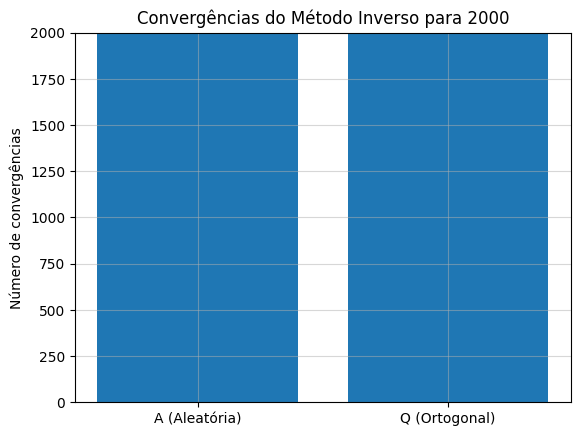

In [ ]:
plt.bar(['A (Aleatória)', 'Q (Ortogonal)'], [a3_num_convergence_A, a3_num_convergence_Q])
plt.title(f'Convergências do Método Inverso para {num_2a}')
plt.ylim((0, num_2a))
plt.grid(alpha=gridAlpha)
plt.ylabel('Número de convergências')
plt.show()

In [ ]:
print(f"Número de convergências para A (aleatório): {a3_num_convergence_A}/{num_2a}")
print(f"Número de iterações médias para A (aleatório): {int(a3_num_iter_A_median)}")
print()
print(f"Número de convergências para Q: {a3_num_convergence_Q}/{num_2a}")
print(f"Número de iterações médias para Q (ortogonal): {int(a3_num_iter_Q_median)}")

Número de convergências para A (aleatório): 2000/2000
Número de iterações médias para A (aleatório): 346

Número de convergências para Q: 2000/2000
Número de iterações médias para Q (ortogonal): 81


## b) Calculando os autovalores de $ A=\begin{pmatrix}  a & b \\  c & d \\\end{pmatrix} $


Queremos um $\lambda$ tal que $det(A - \lambda I) = 0$, então podemos abrir as contas:

$$
(a - \lambda)(d-\lambda) = bc
$$
então,
$$
\lambda^2 - (a + d)\lambda + ad - bc = 0
$$
logo, podemos concluir que
$$
\lambda \isin \set{\frac{tr(A) \pm \sqrt{tr(A)^2 -4det(A)}}{2}}
$$

Agora, supondo que $A$ é ortogonal, temos a relação

$$
\det(A) \isin \set{-1, 1}
$$

In [ ]:
def eigenValues22(A: torch.Tensor):
    """
    Calcula os autovalores de uma matriz 2x2 utilizando a fórmula do polinômio característico.

    Parâmetros:
    - A (torch.Tensor): matriz 2x2.

    Retorna:
    - tuple (lambda_1, lambda_2): autovalores (possivelmente complexos).
    """

    # Elementos da matriz
    a, b = A[0][0], A[0][1]
    c, d = A[1][0], A[1][1]

    # Traço e determinante
    trA = a + d
    detA = a * d - b * c

    # Discriminante do polinômio característico
    delta = trA ** 2 - 4 * detA

    # Fórmula resolvente para raízes do polinômio de segundo grau
    return ((trA - torch.sqrt(delta)) / 2, (trA + torch.sqrt(delta)) / 2)

## c) Testes com matrizes de ordem 4.

- Para analisar os autovalores do bloco inferior direito 2x2 da matriz de hessemberg de $Q$ de $A$, iremos levar em conta todos eles:
- Foram calculados os autovalores dos blocos 2x2 inferiores direitos das seguintes matrizes: $A$(aleatória), $Q$ da decomposição $QR$ de $A$ e $Q_{hessemberg}$ a forma de hessemberg de $Q$.
### Observações feitas.

####  $A[2:4, 2:4]$ **:**
- Os autovalores tendem a ficar perto de $0$, porém não respeitam o círculo unitário. Este fato está relacionado com a criação das matrizes $A$, pois usei a distribuição normal para gerar as entradas dela.

#### $Q[2:4, 2:4]$ **:**
- Os autovalores desse bloco seguem uma interessante regra:
    - Seus módulos jamais são maiores do que 1, visto que a matriz $Q$ em si é ortogonal.
    - Seus módulos ficam perto de 0.8.
#### $QHessemberg[2:4, 2:4]$ **:**
- A distribuição dos autovalores deste bloco no espaço seguem uma forma interessante: 
    - É observado que, para os blocos 2x2 da parte inferior direita das matrizes Q_hessenberg, as normas dos autovalores tendem a ser 1, nunca passando desse valor.
    - Tendem a parte real negativa.
    - Tendem à ter a parte real negativa.

### Conclusões:
Os autovalores do bloco 2x2 inferior direito de $QHessemberg$ tendem a refletir o espaço espectral da matriz $Q$ muito melhor do que seu próprio bloco 2x2. Portanto, caso queiramos escolher algum chute como aproximação para um autovalor de $Q$, Escolher um autovalor do bloco de $QHessemberg$ seria uma boa alternativa.


In [ ]:
def plot_eigens_data(lmbs_list, title, s=1, disp=True, hist=True):
    """
    Plota os autovalores fornecidos em um gráfico complexo e um histograma dos seus módulos.

    Parâmetros:
    - lmbs_list (list[Tensor]): Lista de tensores de autovalores (complexos).
    - title (str): Título para os gráficos.
    - s (int, opcional): Tamanho dos pontos no gráfico de dispersão (default: 1).

    Geração de gráficos:
    - Subplot 1: autovalores no plano complexo, comparando com o círculo unitário.
    - Subplot 2: histograma dos módulos dos autovalores (|lambda|).
    """
    # Círculo unitário
    theta = np.linspace(0, 2 * np.pi, 100)
    x_circle = np.cos(theta)
    y_circle = np.sin(theta)

    # Empilha a lista de tensores em um único tensor 1D de complexos
    lmbs_tensor = torch.stack(lmbs_list).to(dtype=precision)

    # Obtém partes reais, imaginárias e módulos dos autovalores
    moduli = torch.abs(lmbs_tensor)
    real_parts = lmbs_tensor.real
    imag_parts = lmbs_tensor.imag

    # Define número de bins para o histograma (poderia ser adaptativo, mas aqui fixamos)
    num_bins = 100

    if (hist and disp):
        # Inicia figura com 2 subplots
        plt.figure(figsize=(12, 6))

        # Subplot 1: gráfico de dispersão no plano complexo
        plt.subplot(1, 2, 1)
        plt.scatter(real_parts, imag_parts, s=s, alpha=0.6, label=title)
        plt.plot(x_circle, y_circle, 'r--', label='Círculo Unitário (|λ|=1)', alpha=0.8)
        plt.axis('equal')
        plt.xlabel('Parte Real (λ)')
        plt.ylabel('Parte Imaginária (λ)')
        plt.grid(alpha=gridAlpha)
        plt.axhline(0, color='gray', linewidth=0.5)
        plt.axvline(0, color='gray', linewidth=0.5)
        plt.title(f"Distribuição no Plano")
        plt.legend()

        # Subplot 2: histograma dos módulos
        plt.subplot(1, 2, 2)
        plt.hist(moduli.numpy(), bins=num_bins, color='skyblue', edgecolor='black')
        plt.axvline(1.0, color='red', linestyle='-', label='|λ| = 1', linewidth=1, alpha=0.7)
        plt.xlabel('|λ| (módulo)')
        plt.ylabel('Frequência')
        plt.title(f"Módulos")
        plt.legend()
        plt.grid(alpha=gridAlpha)

        # Mostra os gráficos
        plt.suptitle(f'Informações dos autovalores de {title}', fontsize=16)
        plt.tight_layout(rect=[0, 0, 1, 0.95])  
        plt.show()
        return 
    
    if (hist):
        plt.hist(moduli.numpy(), bins=num_bins, color='skyblue', edgecolor='black')
        plt.axvline(1.0, color='red', linestyle='-', label='|λ| = 1', linewidth=1, alpha=0.7)
        plt.xlabel('|λ| (módulo)')
        plt.ylabel('Frequência')
        plt.title(f"Módulos dos Autovalores de {title}")
        plt.legend()
        plt.grid(gridAlpha)

        plt.show()
        return 
    
    if (disp):
        plt.scatter(real_parts, imag_parts, s=s, alpha=0.6, label=title)
        plt.plot(x_circle, y_circle, 'r--', label='Círculo Unitário (|λ|=1)', alpha=0.8)
        plt.axis('equal')
        plt.xlabel('Parte Real (λ)')
        plt.ylabel('Parte Imaginária (λ)')
        plt.grid(gridAlpha)
        plt.axhline(0, color='gray', linewidth=0.5)
        plt.axvline(0, color='gray', linewidth=0.5)
        plt.title(f"Distribuição no Plano dos Autovalores de {title} ")
        plt.legend()
        
        plt.show()        
        return 

In [ ]:
c_2_norms = []
c_2_lmbs_list_Q_hessenberg = []
c_2_lmbs_list_A = []
c_2_lmbs_list_Q = []

for _ in range(num_2c):
    A = torch.randn((4,4), dtype=precision, )
    Q, _= torch.linalg.qr(A)
    _, Q_Hessenberg, _ = to_hessemberg(Q)

    lmbs = eigenValues22(Q_Hessenberg[2:4, 2:4])
    c_2_lmbs_list_Q_hessenberg.append(lmbs[0])
    c_2_lmbs_list_Q_hessenberg.append(lmbs[1])
    lmbs = eigenValues22(A[2:4, 2:4])
    c_2_lmbs_list_A.append(lmbs[0])
    c_2_lmbs_list_A.append(lmbs[1])
    lmbs = eigenValues22(Q[2:4, 2:4])
    c_2_lmbs_list_Q.append(lmbs[0])
    c_2_lmbs_list_Q.append(lmbs[1])


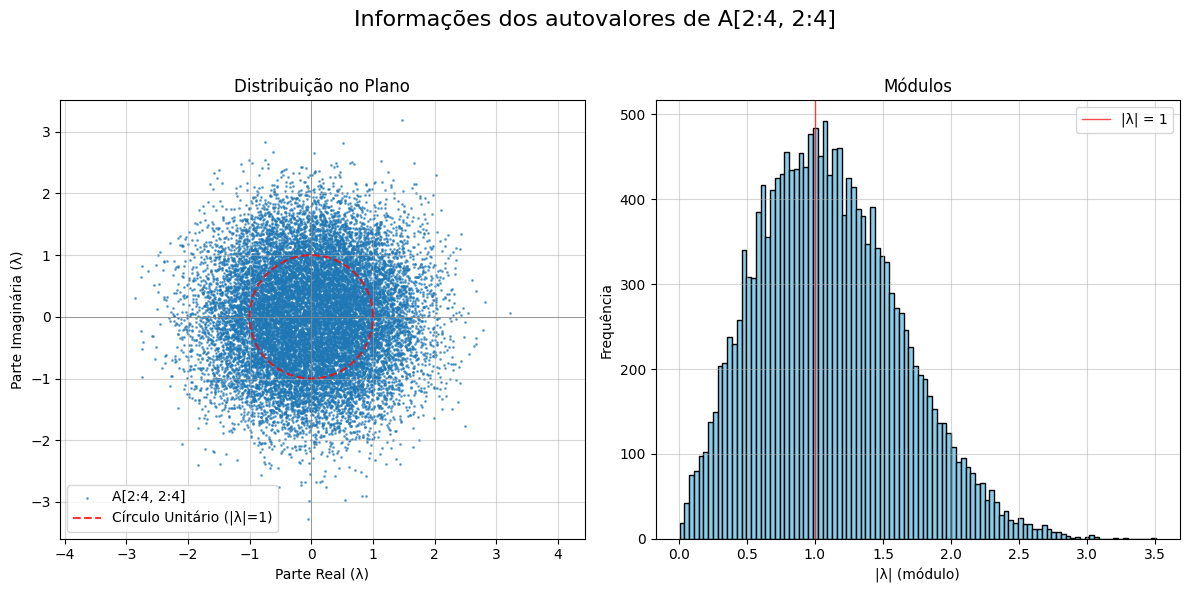

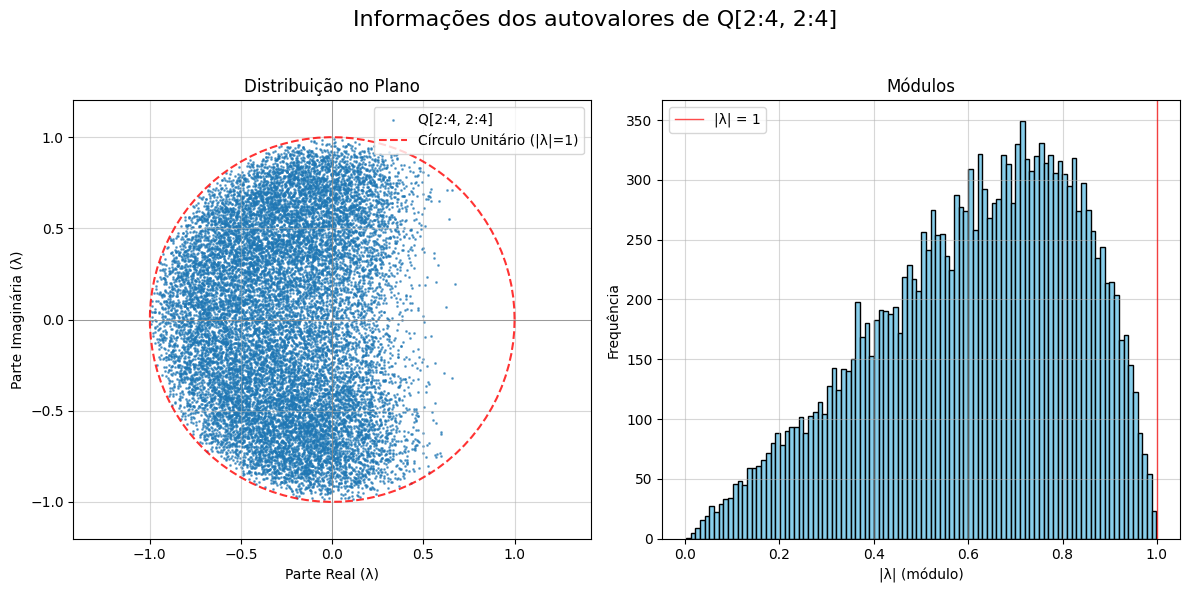

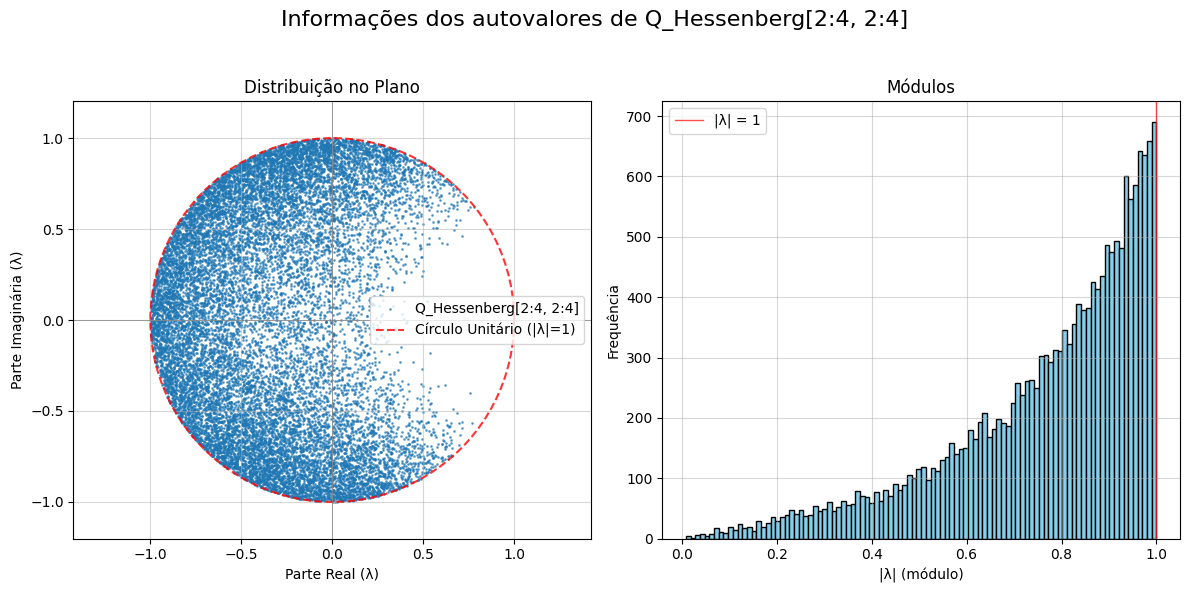

In [ ]:
plot_eigens_data(c_2_lmbs_list_A, "A[2:4, 2:4]")
plot_eigens_data(c_2_lmbs_list_Q, "Q[2:4, 2:4]")
plot_eigens_data(c_2_lmbs_list_Q_hessenberg, "Q_Hessenberg[2:4, 2:4]")

## d) Shifts.

### Ideia
- Podemos utilizar o autovalor do bloco 2x2 mais próximo do último elemento da diagonal como shift.
- Para analisar os benefícios de usar o autovalor do bloco 2x2 como shift, iremos considerar o número de iterações e a distância da resposta ideal (Pytorch). Também comparando com a escolha de um shift aleatório.
- É esperado que o shift escolhido como sendo o autovalor do bloco 2x2 mais próximo do último elemento da diagonal seja uma melhor opção do que aleatórios.

### Conclusão
- Fica claro que, usando o autovalor do bloco 2x2 inferior direito, especificamente, o mais próximo do último elemento direito da diagonal principal, o algoritmo da iteração QR passa a convergir muito mais e obter um resultado muito mais favorável na maioria dos casos.


In [ ]:
def practicalQR(A, maxIter=max_iter_praticalQR, tol=1e-12, u=None, countOnly=False):
    """
    Executa o algoritmo QR prático com ou sem shift para encontrar os autovalores de uma matriz.

    Parâmetros:
    - A (tensor 2D): Matriz quadrada (idealmente em forma de Hessenberg).
    - maxIter (int): Número máximo de iterações permitidas (padrão: 1000).
    - tol (float): Tolerância para considerar elementos da subdiagonal como zero (padrão: 1e-12).
    - printSteps (bool): Se True, imprime aviso caso o número máximo de iterações seja atingido.
    - u (float, opcional): Valor de shift para acelerar a convergência. Se None, usa A[-1, -1].
    - countOnly (bool): Se True, a função retorna apenas o número de iterações (não usado diretamente aqui).
    - trackSubdiag (bool): Se True, armazena e acompanha as normas dos elementos subdiagonais a cada iteração.

    Retorno:
    - (list[float], int): Lista de autovalores aproximados e o número de iterações realizadas.
    """
    A = A.clone().to(dtype=precision)  # Garante cópia da matriz e tipo numérico desejado
    n = A.shape[0]

    # Caso base: matriz 1x1
    if n == 1:
        return [A[0, 0]], 0

    # Caso base: matriz 2x2 — calcula os autovalores analiticamente
    if n == 2:
        tr = A[0, 0] + A[1, 1]
        det = A[0, 0]*A[1, 1] - A[0, 1]*A[1, 0]
        delta = torch.sqrt(tr**2 - 4*det)
        return [(tr + delta)/2, (tr - delta)/2], 0

    iter_count = 0
    while iter_count < maxIter:
        # Verifica convergência por elementos pequenos na subdiagonal
        for p in reversed(range(n - 1)):
            if abs(A[p+1, p]) < tol:
                # Força o elemento a ser zero e divide o problema em blocos
                A[p+1, p] = A[p, p+1] = 0.0
                eigs1, c1 = practicalQR(A[:p+1, :p+1], maxIter, tol, u, countOnly)
                eigs2, c2 = practicalQR(A[p+1:, p+1:], maxIter, tol, u, countOnly)
                return eigs1 + eigs2, iter_count + c1 + c2

        # Aplicação do shift (valor padrão: canto inferior direito)
        if u is None:
            u = A[-1, -1]
        Q, R = torch.linalg.qr(A - u * torch.eye(n, dtype=A.dtype))
        A = R @ Q + u * torch.eye(n, dtype=A.dtype)

        iter_count += 1

    # Retorna os elementos da diagonal principal como autovalores
    return [A[i, i] for i in range(n)], iter_count

In [ ]:
def autovalor_erro(aprox_vals, true_vals):
    """
    Calcula o erro entre os autovalores aproximados e os autovalores reais.

    Os autovalores são ordenados e considerados apenas suas partes reais.
    A função retorna a norma da diferença entre os vetores ordenados de autovalores.

    Parâmetros:
    - aprox_vals (iterável): Lista ou tensor com os autovalores aproximados (possivelmente complexos).
    - true_vals (iterável): Lista ou tensor com os autovalores verdadeiros (possivelmente complexos).

    Retorno:
    - float: Erro (norma 2) entre os autovalores reais aproximados e os reais verdadeiros.
    """
    aprox_vals_sorted = torch.sort(torch.real(torch.tensor(aprox_vals)))[0]
    true_vals_sorted = torch.sort(torch.real(true_vals))[0]
    return torch.linalg.norm(aprox_vals_sorted - true_vals_sorted).item()

In [ ]:
d_2_erros_shift_bom = []
d_2_erros_shift_aleatorio = []
d_2_iters_random_list = []
d_2_iters_shift_list = []

for _ in range(num_2d):
    # Matriz ortogonal
    A = torch.randn((4,4), dtype=precision)
    Q, _ = torch.linalg.qr(A)
    
    # Forma de Hessenberg
    _, Q_Hessenberg, _ = to_hessemberg(Q)

    # Shift a partir do bloco 2x2 final
    lmb0, lmb1 = eigenValues22(Q_Hessenberg[2:4, 2:4]) 
    lmb_bom = lmb0 if torch.linalg.norm(lmb0 - Q_Hessenberg[3,3]) < torch.linalg.norm(lmb1 - Q_Hessenberg[3,3]) else lmb1

    # Autovalores reais (torch)
    true_eigs = torch.linalg.eigvals(Q_Hessenberg)

    # Com shift bom
    eigs_bom, iters_shift = practicalQR(Q_Hessenberg, u=lmb_bom)
    erro_shift = autovalor_erro(eigs_bom, true_eigs)
    d_2_erros_shift_bom.append(erro_shift)
    d_2_iters_shift_list.append(iters_shift)

    # Com shift aleatório
    eigs_aleat, iters_random = practicalQR(Q_Hessenberg)
    erro_aleat = autovalor_erro(eigs_aleat, true_eigs)
    d_2_erros_shift_aleatorio.append(erro_aleat)
    d_2_iters_random_list.append(iters_random)

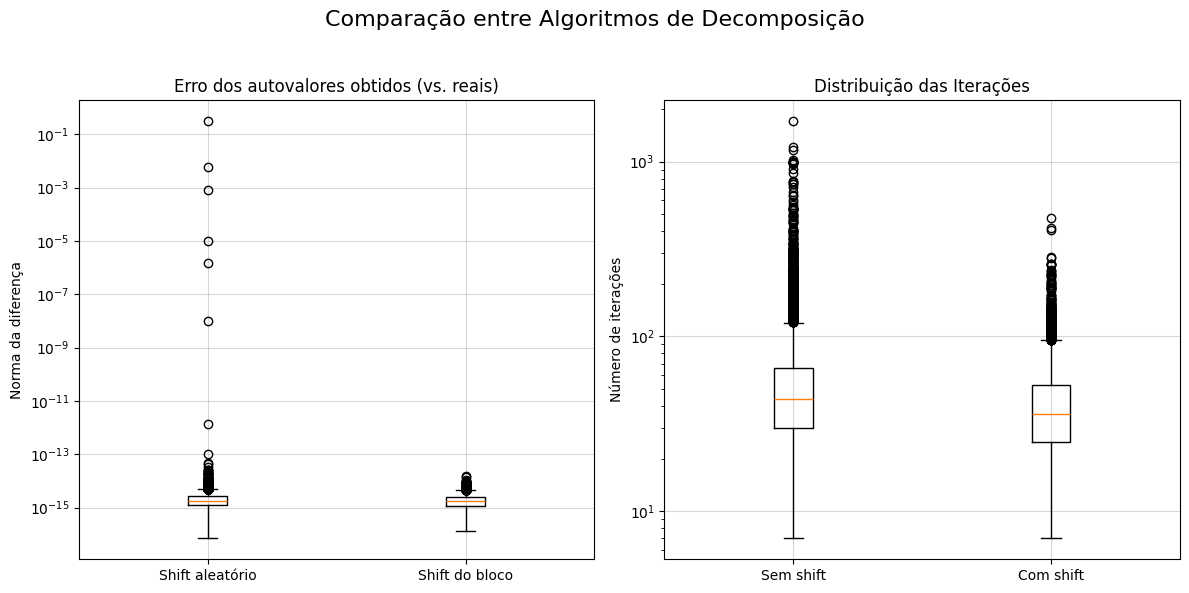

In [ ]:
plt.figure(figsize=(12,6))

plt.subplot(1,2,1)
plt.boxplot([d_2_erros_shift_aleatorio, d_2_erros_shift_bom], tick_labels=["Shift aleatório", "Shift do bloco"])
plt.title("Erro dos autovalores obtidos (vs. reais)")
plt.ylabel("Norma da diferença")
plt.grid(alpha=gridAlpha)
plt.yscale("log")  # escala log para mostrar diferenças pequenas

plt.subplot(1,2,2)
plt.boxplot([d_2_iters_random_list, d_2_iters_shift_list], tick_labels=['Sem shift', 'Com shift'])
plt.title('Distribuição das Iterações')
plt.ylabel('Número de iterações')
plt.grid(alpha=gridAlpha)
plt.yscale('log')


plt.suptitle('Comparação entre Algoritmos de Decomposição', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])  



plt.show()

In [ ]:
print(f"Erro médio com shift aleatório: {sum(d_2_erros_shift_aleatorio)/num_2d:.2e}")
print(f"Erro médio com shift do bloco: {sum(d_2_erros_shift_bom)/num_2d:.2e}")
print(f"Número de iterações médias com shift aleatório: {int(sum(d_2_iters_random_list)/num_2d)}")
print(f"Número de iterações médias com shift do bloco: {int(sum(d_2_iters_shift_list)/num_2d)}")

Erro médio com shift aleatório: 3.16e-05
Erro médio com shift do bloco: 1.99e-15
Número de iterações médias com shift aleatório: 58
Número de iterações médias com shift do bloco: 42
